## Descenso de gradiente para regresión lineal

En el ejercicio anterior aprendiste regresión lineal y encontraste una solución analítica a través de algebra lineal, ahora resolveremos el mismo problema llegando a la solución de manera iterativa. 

En la práctica, descenso de gradiente se utiliza en problemas en los que obtener una solución analítica no es posible como regresión logística o redes neuronales.

(200, 2) (100, 2)


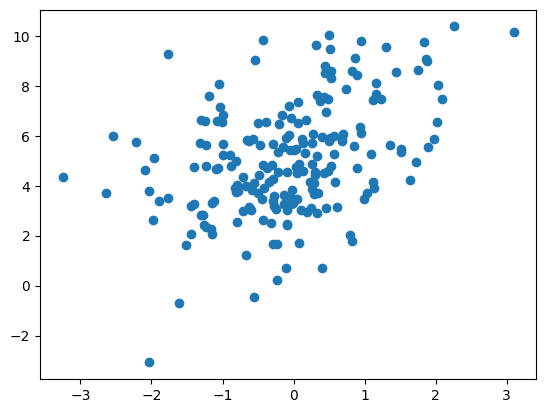

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Nuevamente generamos los datos aleatorios con una desviación estandar conocida
# Alrededor de una funcion lineal conocida y = 1.2x + 0.7
n_samples = 300
ruido_blanco_std = 2
X = np.random.randn(n_samples, 1)
for_bias = np.ones([n_samples, 1])
X_augmented = np.concatenate([for_bias, X], axis=-1)
eps = np.random.randn(n_samples, 1) * ruido_blanco_std
ideal_w = [[5], [1.2]]
target_y = X_augmented @ ideal_w + eps

# Dividir en entrenamiento y validación
n_val_dp = n_samples//3
x_train = X_augmented[:-n_val_dp,:]
y_train = target_y[:-n_val_dp]

x_val = X_augmented[-n_val_dp:,:]
y_val = target_y[-n_val_dp:]

print(x_train.shape, x_val.shape)
# Graficar set de entrenamiento
plt.scatter(x_train[:,-1], y_train)

## Función de pérdida
Ya que hemos cargado el dataset y sabemos como está compuesto, debemos calcular la función de pérdida

$ MSE = J(w) = \frac{1}{2n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i)^2 $

In [12]:
def mse_loss(y, y_pred):
    """
        Regresa el error cuadrático promedio de todas las predicciones
        y: shape=N Etiquetas
        y_pred: predicciones del modelo
    """
    # TODO: Calcula el resultado de la función de pérdida
    # ====== Start of solution =====
    loss = np.mean((y - y_pred)**2, axis=0)
    return loss/2
    # ====== End of solution =====

# Iniciamos con unos parametros w arbitrarios
w = np.random.uniform(-10, 10, size=(2, 1))

# TODO: Calcula las preddiciones para el conjunto de entrenamiento x_train
y_pred = x_train @ w
# TODO: Calcula la función de pérdida para las predicciones(y_pred) y los valores reales (y_train)
# ====== Start of solution =====
train_loss = mse_loss(y_train, y_pred)
print('El valor de pérdida es:', train_loss)
# ====== End of solution =====

El valor de pérdida es: [73.29480849]


Podemos visualizar como se ve la función de pérdida con diferentes pesos.
Si elegimos los pesos que generan la menor pérdidda en el set habremos encontrado los parametros ideales para este problema.

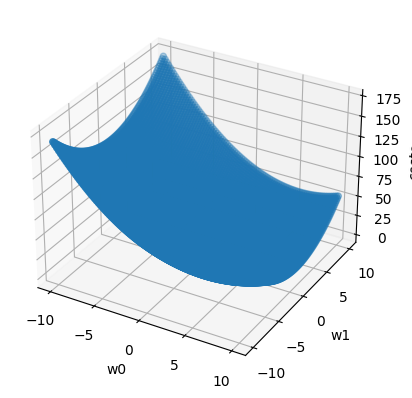

In [13]:
# Probaremos con 100x100 combinaciones de distintos parametros
w0 = np.linspace(-10, 10, 100)
w1 = np.linspace(-10, 10, 100)
w0w0, w1w1 = np.meshgrid(w0, w1)
w0_flat = w0w0.ravel()
w1_flat = w1w1.ravel()
W = np.stack([w0_flat, w1_flat], axis=0)


# Calculamos la función de pérdida
# TODO: calcula el costo de las predicciones (y_pred) contra etiquetas (y_train)
# usando las 100x100 combindaciones de parametros (W)
# ====== Start of solution =====
y_pred = x_train @ W
calc_cost = mse_loss(y_train, y_pred)
# ====== End of solution =====

# Graficamos los parametros w con su respectivo costo en el eje de las x
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(w0_flat, w1_flat, calc_cost)

# TODO: Escribe a qué valor corresponde cada eje
# ====== Start of solution =====
ax.set_xlabel("w0")
ax.set_ylabel("w1")
ax.set_zlabel("costo")
# ====== End of solution =====
plt.show()

(300, 1) (300, 2) (300, 1)


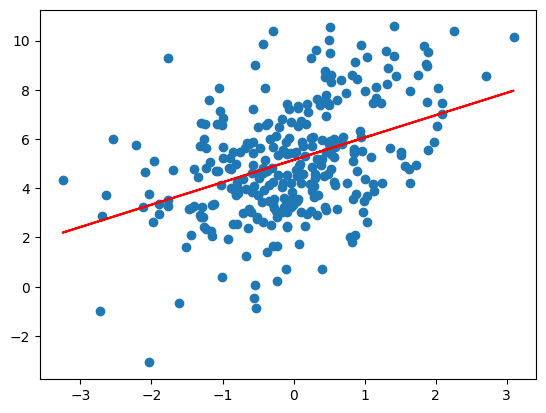

In [16]:
# Podemos encontrar la combinación de pesos que minimizan la pérdida
# Y de esta manera encontrar los pesos ideales
best_idx = np.argmin(calc_cost)
search_w0 = w0_flat[best_idx]
search_w1 = w1_flat[best_idx]
search_w = [[search_w0], [search_w1]] 

plt.scatter(X, target_y)
# TODO: Grafica la línea de regresión generada por tu modelo search_w
# Encima de las muestras dadas
# ====== Start of solution =====
pred_y = X_augmented @ search_w
print(X.shape, X_augmented.shape, pred_y.shape)
plt.plot(X, pred_y, c='r')
# ====== End of solution =====

En el código anterior evaluamos $100 \times 100$ combinaciones de pesos posibles y encontramos los mejores pesos. En este caso solo tenemos 2 parametros que queremos estimar, por lo que encontrar la solución de esta manera es factible al tener que realizar alrededor de $100^2$ evaluaciones de la función. 

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de pérdida tendríamos que hacer si tuviéramos 4 parametros?
100^4
- ¿Qué pasaría si tuviéramos 1 millon de parametros?
100^1000000

Las redes neuronales tienen millones de parametros para hacer predicciones, por lo que encontrar la solución de esta manera no es factible. Se han encontrado formas más eficientes de encontrar la solución por ejemplo, a través de métodos iterativos. Uno de ellos es decenso de gradiente. Siguiendo la direccion contraria del gradiente de la pérdida con respecto a los pesos, podemos encontrar los parámetros que <b>minimizan</b> la función de pérdida utilizando menos evaluaciones.

## Descenso de gradiente
En esta sección, optimizarás la función de regresión lineal a través de descenso de gradiente.
La predicción de nuestro modelo está dada con la siguiente funcion:

$ \hat{Y}_i = w_0 + w_1 * x$

$\hat{Y} = \mathbf{X}\mathbf{w}$

<!-- El gradiente de MSE con respecto a $w_0$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_0} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_0}= \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) $

El gradiente de MSE con respecto a $w_1$ se calcula de la siguiente manera

$ \frac{\partial J(w)}{\partial w_1} = \frac{\partial J(w)}{\partial \hat{Y}_i} * \frac{\partial \hat{Y}_i}{\partial w_1} = \frac{1}{n} \sum_{i=1}^{n} (\hat{Y}_i - Y_i) * x_i $ -->

Donde:
- $\hat{Y}_i \in  \hat{Y}$
- $\mathbf{Y} \in \mathbb{R}^{N}$
- $\mathbf{X} \in  \mathbb{R}^{N \times D+1}$ en notación aumentada
- $\mathbf{w} \in \mathbb{R}^{D+1}$ en notación aumentada

Como vimos en clase, el gradiente la función de costo con respecto a los pesos está dado por:

 $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}} = -\frac{1}{N}X^T\epsilon$

 donde $\epsilon=\mathbf{Y}-\mathbf{X}\mathbf{w}$

 TODO: Completa el código necesario para aplicar descenso de gradiente durante n_iteraciones. Para ello realiza los siguientes pasos:
- Calcula el valor de las predicciones $\mathbf{Y}$
- Calcula el gradiente de la función a optimizar $\frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Actualiza los pesos con el gradiente $\mathbf{w}^{i+1} = \mathbf{w}^{i} - \alpha \frac{\partial J(\mathbf{w})}{\partial \mathbf{w}}$
- Repite hasta optener el valor óptimo de $\mathbf{w}$

Es tiempo de programarlo en código

In [25]:
def gradient_descent(X, y, lr, N_iterations, w_start=np.array([0,0])):
    """
    Entradas:
    X: arreglo con los datos en notación aumentada X
    y: vector de etiquetas
    lr: ritmo de aprendizaje
    N_iterations: cantidad de iteraciones de optimización
    w_start: pesos iniciales
        
    Regresa:  
    w_opt: pesos óptimos
    cost_history: arreglo con el valor de costo para cada iteración
    """
    m = X.shape[0]
    
    # initialize the coefficients
    w=w_start
    
    for i in range(N_iterations):
        # ====== Start of solution =====
        # TODO: Calcula la predicción 
        hypothesis = X @ w

        # TODO: Calcula el error
        error = y - hypothesis

        # TODO: Calcula el gradiente del MSE loss
        gradient = -X.T @ (error)/m

        # TODO: Actualiza los pesos
        w = w - lr * gradient
        
        # ====== End of solution =====
        # Calculamos la función de pérdida y guardamos el resultado
        loss = mse_loss(y, hypothesis)
        #print(f"it {i} \t loss {loss}")
        
    print(f"Total de evaluaciones {i}, la pérdida final fue {loss}")
    w_opt=w
    return w_opt

Total de evaluaciones 49, la pérdida final fue [5.51683114]
Total de evaluaciones 59, la pérdida final fue [2.58249739]
Total de evaluaciones 79, la pérdida final fue [2.13708228]


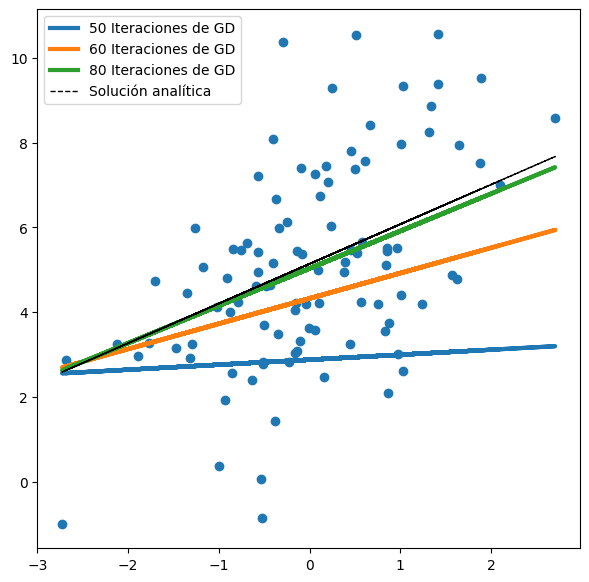

In [30]:
from sklearn import linear_model
# Parámetros de descenso de gradiente
N_iterations = [50,60,80]

# Pesos iniciales y ritmo de aprendizaje
lr = 0.1  # Utiliza valores cercanos e.g. 0.05, 0.2 .. etc
w_start = np.array([-400,0])
w_start = np.expand_dims(w_start,-1)

# (2.) - (4.) -> Variación de cantidad de iteraciones
plt.figure(figsize=(7,7))
plt.scatter(x_val[:,-1], y_val)
for n_it in N_iterations:
    # Entrenamos el modelo en el set de entrenamiento
    w_opt = gradient_descent(x_train, y_train, lr, n_it, w_start)

    # Visualizamos la predicción en el set de validación
    prediction = x_val @ w_opt
    plt.plot(x_val[:,-1], prediction, label = str(n_it)+" Iteraciones de GD", linewidth=3)

# Obtener la solución analítica
analitic_sol=linear_model.LinearRegression()
analitic_sol.fit(x_train, y_train)

# Visualizar solución analitica
plt.plot(x_val[:,-1], analitic_sol.predict(x_val),label = 'Solución analítica', linewidth=1, linestyle="dashed", color="black")
# plt.ylim(bottom=-10)
plt.legend()
plt.show()

<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Cuántas evaluaciones de la función de pérdida se evaluaron para encontrar la solución con un $lr=0.1$?
80
- ¿Cómo se compara este número a la solución por busqueda exhaustiva? 
Es mucho mas rapido el descenso de gradiente, ya que se ocupan menos iteraciones
- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) a un valor dos veces grande?
Llega mas rápido
- ¿Qué pasa si cambiamos la tase de aprendizaje a un valor dos veces más chico?
Tarda el doble
- ¿Qué pasa si cambiamos la tasa de aprendizaje (lr) por un valor muy grande?
Diverge

# Regresión logística
En este ejercicio exploraremos el uso de Regresión logística. Primero programarás los elementos necesarios para optimizar la función por descenso de gradiente y después usaremos las librerias de scikit-learn para encontrar la solución. 

Regresión logística nos sirve para resolver problemas de <b>clasificación</b>, esto consiste en utilizar datos para estimar un valor discreto que será asignado a una categoría, en el siguiente código nos enfocaremos especificamente en clasificación 
binaria.

Para entender mejor los conceptos utilizaremos el ["Breast cancer wisconsin (diagnostic) dataset"](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer). Este dataset contiene distintos atributos para determinar si un tumor es maligno(0) o benigno(1). Antes de empezar analizaremos el dataset.

In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import numpy as np

dataset = load_breast_cancer()
# Podemos visualizar los atributos del dataset y la dimensionalidad de los datos
print("Nobres de las columnas:", dataset.keys())
print("Matriz de datos (X.shape -> NxD): ", dataset['data'].shape)
print("Cantidad de datos(N): ", dataset['target'].shape)
print("Clases: 0-> %s, 1-> %s" %(dataset.target_names[0], dataset.target_names[1]))

In [ ]:
# Podemos visualizar los nombres de los datos para decidir que atributos utilizar.
# En este caso utilizaremos la textura y el perímetro del tumor para generar la predicción.
print(dataset['feature_names'][[21, 22]])
print(dataset['target_names']) 

# Haremos el split de los datos y a partir de ahora solo usaremos
# el conjunto de entrenamiento para encontrar nuestro modelo
data_train, data_test, target_train, target_test = train_test_split(
    dataset['data'][:, [21, 22]], 
    dataset['target'], 
    test_size=0.25
)

# TODO: Imprime la cantidad de puntos que serán dedicados para entrenamiento y
# para prueba
# ====== Start of solution =====
print(f"Entrenamiento - {...} datapoints")
print(f"Evaluación - {...} datapoints")
# ====== End of solution =====

# Es bueno saber como es la distribución de los datos
# Incluyendo cuantos ejemplos son benignos y malignos
malignant_idcs = np.where(target_train == 0)
benign_idcs = np.where(target_train == 1)

# TODO: Imprime la cantidad de puntos que son malignos y benignos
# ====== Start of solution =====

# ====== End of solution =====

## Visualización de datos
Antes de resolver cualquier problema es necesario entenderlo, para los problemas de aprendizaje máquina una de las herramientas mas importantes para comprender mejor a que nos enfrentamos es el visualizar los datos.

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4))

# Pintaremos los que tienen etiqueta 0 y etiqueta 1 de distinto color
# Muestra un máximo de dp_to_plot puntos para cada clase
dp_to_plot = 100

# Grafica los datos malignos
malignant_entries = data_train[malignant_idcs]
ax.scatter(
    # TODO: Ingresa los datos a graficar
    # ====== Start of solution =====
    x=...,
    y=...,
    # ====== End of solution =====
    s=100,
    color="r", 
    marker="x",
    label="maligno"
)

# Grafica los datos benignos
benign_entries = data_train[benign_idcs]
ax.scatter(
    # TODO: Ingresa los datos a graficar
    # ====== Start of solution =====

    # ====== End of solution =====
    s=100,
    color="b", 
    edgecolor='black',
    marker="o",
    label="benigno"
)
plt.legend()
plt.show()


## La función sigmoide
Podemos aplicar un modelo de regresión logística para encontrar el límite de separación que nos permita clasificar nuevos tumores, a partir de los datos de entrenamiento.Recordamos la función logística vista en clase:

$ h_w(z) = \frac{1}{1 + e^{-z}}$

En la siguiente celda, visualiza la función logística.

In [ ]:
def logistic(z):
    # TODO: Calcula la hipótesis h(z)
    # ====== Start of solution =====
    h = ...
    # ====== End of solution =====
    return h

x = np.linspace(-10, 10, 100)
y = logistic(x)
# TODO: Grafica la función logística
# ====== Start of solution =====

# ====== End of solution =====

Si queremos aprender un modelo de regresión logística, debemos encontrar los parámetros w que minimizen la función de pérdida. En regresión logística, el modelo de decisión consiste en:

$ h_w(X) = \frac{1}{1 + e^{-Xw}}$

Donde:
- $X$ corresponde a los datos proporcionados
- $h_w(X)$ es la predicción o hipótesis de nuestro modelo de regresión logística

Recuerda que para realizar las operaciones de manera correcta $X$ debe estar en su notación aumentada, es decir, tiene un uno adicional por cada datapoint para que se pueda añadir el sesgo: $X \in \mathbb{R}^ {D+1 \times N }$. Por lo tanto, los pesos tienen este parámetro adicional también $ w \in R^{D+1} $

En este problema $D = 2$ ya que estamos utilizando el perímetro y la textura del tumor para hacer la predición.

TODO: En la siguiente celda, calcula las predicciones de regresión logística para una inicialización aleatoria de los pesos $w$

In [ ]:
# Inicializando W
w = np.random.uniform(low=-1, high=1, size=(3,))

# TODO: Genera el dataset de entrenamiento aumentado
# para el conjunto de datos de entrenamiento data_train
# aug_data_train = ?
# ====== Start of solution =====
aug_data_train = ...
# ====== End of solution =====

# TODO: Calcula el valor de z/ la combinación lineal de los pesos y datos de entrenamiento
# ====== Start of solution =====
z = ...
# ====== End of solution =====
pred = logistic(z)

print(aug_data_train.shape)
print(pred.shape)

# Graficamos los puntos para visualizar la predicción de nuestro modelo actualmente
plt.scatter(aug_data_train[:, 1],aug_data_train[:, 2], c=pred, cmap="RdYlGn")
plt.colorbar()

## Función de pérdida
Como vemos, al inicializarse los pesos, el modelo clasifica la mayoría de los puntos como benignos(0), sin embargo una vez optimizada la función, el modelo aprende el valor de los pesos óptimos dados los datos de entrenamiento. Para optimizar los pesos necesitamos aplicar descenso de gradiente usando la función de pérdida.

En clase vimos que la función de pérdida que se utiliza para problemas de clasificación binaria, se conoce como binary cross entropy loss (BCE)

$ L(h_w(x), y) = - y \log(h_w(x)) - (1 - y)\log(1 - h_w(x)) $

La funcion de logaritmo $\log{x}$ tiende al infinito cuando $x=0$. Para evitar esto, es común agregar un valor muy pequeño $\epsilon$ al valor dentro del logaritmo.

$ L(h_w(x), y) = - y \log(h_w(x) + \epsilon) - (1 - y)\log(1 - h_w(x) + \epsilon) $

Termina el método para calcular la función de pérdida correspondiente.

In [ ]:
def bce_loss(X, w, y):
    """
        X: datos en notación aumentada,
        w: pesos del modelo
        y: etiquetas de los datos
    """
    eps = 1e-5 
    # TODO: Calcula la función de pérdida
    # Nota - suma la variable eps dentro del logaritmo 
    # para evitar errores por números muy cercanos a log de 0
    # ====== Start of solution =====
    loss = ...
    # ====== End of solution ======
    return loss.mean(axis=0)

loss = bce_loss(aug_data_train, w, target_train)
print("Costo: %.3f" %loss)

## Optmización
Podemos resolver el problema anterior utilizando descenso por gradiente. Para ello, requeriríamos sacar el gradiente de la función de pérdida con respecto a los pesos e iterar como en el ejercicio de regresión lineal. Es decir, necesitaríamos el gradiente del BCE loss, por lo tanto no podemos usar la función anteriormente calculada ya que utilizamos un loss diferente (MSE).

En esta ocasión resolveremos el problema con la librería de scikit-learn. Completa donde se indique.

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
# TODO: Haz fit al modelo de regresión logística
# usando los datos de entrenamiento
# (data_train, target_train)
# ====== Start of solution =====

# ====== End of solution =====

# TODO: Calcula las preddiciones
# ====== Start of solution =====
prediction = ...
# ====== End of solution =====

# TODO: Calcula la exactitud de tu predicción
# en el set de entrenamiento (data_train, target_train)
# Es decir, el promedio de datos correctamente clasificados
# ====== Start of solution =====
train_accuracy = ...
# ====== End of solution =====

# TODO: Calcula la probabilidad de que un tumor sea benigno
# en el set de evaluación (data_test, target_test)
# La dimensionalidad de prob debe ser (test_dp, )
# Tip: Investiga la función "LogisticRegression.predict_proba"
# ====== Start of solution =====
prob = ...
# ====== End of solution =====

# TODO: Calcula la exactitud de tu predicción
# en el set de evaluación (data_test, target_test)
# Tip: Investiga la función "LogisticRegression.score"
# ====== Start of solution =====
test_accuracy = ...

# ====== End of solution =====
print(test_accuracy)

# Graficamos los puntos para visualizar la predicción de nuestro modelo
plt.scatter(data_test[:, 0],data_test[:, 1], c=prob, cmap="RdYlGn")
plt.colorbar()

En la celda anterior, calculamos una predicción para cada punto de evaluación. Específicamente, el color de cada punto indica una probabilidad de que el tumor correspondiente sea benigno. 
<b>TODO: Contesta las siguientes preguntas</b> 
- ¿Por qué es útil predecir la probabilidad de que el tumor sea benigno en lugar de decir con certeza qué tipo de tumor es? 
- Intuitivamente ¿Qué necesitarías para tener una predicción más acertada?
- Menciona otro problema real que se pueda resolver con un modelo de clasificación.